# Parametric simulation using accim custom models

In [1]:
#todo import qgrid to manually change output dfs

In [2]:
import accim
import accim.parametric_and_optimisation.funcs_for_besos.param_accis as bf
from accim.parametric_and_optimisation.objectives import return_time_series
from accim.parametric_and_optimisation.utils import make_all_combinations
from besos import eppy_funcs as ef
import matplotlib.pyplot as plt
import seaborn as sns
from accim.utils import print_available_outputs_mod, get_accim_args
from accim.parametric_and_optimisation.main import OptimParamSimulation, get_rdd_file_as_df, get_mdd_file_as_df, parse_mtd_file
from os import listdir


Let's have a look at the files we currently have in the path:

In [3]:
original_files = [i for i in listdir()]
original_files

['param_sim_accim_custom_model.ipynb',
 'Seville.epw',
 'Sydney.epw',
 'TestModel.idf']

Firstly, the IDF must be read using besos's `get_building` function.

In [4]:
building = ef.get_building('TestModel.idf')

For this analysis, we want to use the HVAC system in all hours of the year, so that temperature is always comfortable. Therefore, we are going to set the occupancy to always on by means of the function `accim.utils.set_occupancy_to_always`, in which we input the IDF class instance we read in the previous cell.

In [5]:
accim.utils.set_occupancy_to_always(idf_object=building)

On 24/7 Schedule:Compact object was already in the model.
People Block1:Zone2 Number of People Schedule Name has been set to always occupied.
People Block1:Zone1 Number of People Schedule Name has been set to always occupied.


Now, let's start with the settings for the parametric analysis. First, let's instantiate the class `OptimParamSimulation`, and let's pass the IDF instance in the argument `building`. Argument `parameters_type` can take 3 different strings:
- "accim predefined model", in which models are those previously defined in accim (ComfStand=0 to ComfStand=22);
- "accim custom model", in which key parameters of the adaptive comfort model are defined in the relevant arguments;
- "apmv setpoints", in which setpoints are based on the aPMV (Adaptive Predicted Mean Vote) instead of the PMV index;

In this case, we're going to use the 'accim custom model' type, in which we can define the adaptive comfort model.

In [6]:
parametric = OptimParamSimulation(
    building=building,
    parameters_type='accim custom model',
    #output_type='standard', #
    #output_keep_existing=False, #
    #output_freqs=['hourly'], #
    #ScriptType='vrf_mm', #
    #SupplyAirTempInputMethod='temperature difference', #
    #debugging=True, #
    #verbosemode=False #
)


--------------------------------------------------------
Adaptive-Comfort-Control-Implemented Model (ACCIM) v0.7.5.2
--------------------------------------------------------

This tool allows to apply adaptive setpoint temperatures. 
For further information, please read the documentation: 
https://accim.readthedocs.io/en/master/
For a visual understanding of the tool, please visit the following jupyter notebooks:
-    Using addAccis() to apply adaptive setpoint temperatures
https://accim.readthedocs.io/en/master/jupyter_notebooks/addAccis/using_addAccis.html
-    Using rename_epw_files() to rename the EPWs for proper data analysis after simulation
https://accim.readthedocs.io/en/master/jupyter_notebooks/rename_epw_files/using_rename_epw_files.html
-    Using runEp() to directly run simulations with EnergyPlus
https://accim.readthedocs.io/en/master/jupyter_notebooks/runEp/using_runEp.html
-    Using the class Table() for data analysis
https://accim.readthedocs.io/en/master/jupyter_note

An initial and generic version of the Adaptive-Comfort-Control-Implementation Script (ACCIS) has been added to the idf instance `building`. For instance, you can take a look at the parameter values accis currently has:

In [7]:
[i for i in building.idfobjects['energymanagementsystem:program'] if i.Name.lower() == 'setinputdata']

[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     SetInputData,             !- Name
     set ComfStand = 1,        !- Program Line 1
     set CAT = 1,              !- Program Line 2
     set ComfMod = 2,          !- Program Line 3
     set HVACmode = 2,         !- Program Line 4
     set VentCtrl = 0,         !- Program Line 5
     set VSToffset = 0,        !- Program Line 6
     set MinOToffset = 7,      !- Program Line 7
     set MaxWindSpeed = 6,     !- Program Line 8
     set ACSTtol = -0.25,      !- Program Line 9
     set AHSTtol = 0.25,       !- Program Line 10
     set CoolSeasonStart = 121,    !- Program Line 11
     set CoolSeasonEnd = 274;    !- Program Line 12]

## Setting the outputs

**If you have already read any of the other parametric simulation examples, you can skip this entire outputs section, since it is exactly the same.**

### Outputs for the idf (i.e. the outputs for each simulation run)

First of all, we are going to set the outputs of the simulations that are going to be performed. This is an important step, especially if you are going to run hundreds or thousands of simulations.

Let's take a look at the Output:Variable objects we currently have in the idf. The method `get_output_var_df_from_idf()` returns a pandas DataFrame which contains the information of the existing Output:Variable objects in the idf:

In [8]:
df_output_variables_idf = parametric.get_output_var_df_from_idf()
df_output_variables_idf

,key_value,variable_name,reporting_frequency,schedule_name
0,*,Comfort Temperature,Hourly,
1,*,Adaptive Cooling Setpoint Temperature,Hourly,
2,*,Adaptive Heating Setpoint Temperature,Hourly,
3,*,Adaptive Cooling Setpoint Temperature_No Toler...,Hourly,
4,*,Adaptive Heating Setpoint Temperature_No Toler...,Hourly,
...,...,...,...,...
72,*,VRF Heat Pump Heating Electricity Energy,Hourly,
73,BLOCK1_ZONE2 VRF Indoor Unit DX Cooling Coil,Cooling Coil Total Cooling Rate,Hourly,
74,BLOCK1_ZONE2 VRF Indoor Unit DX Heating Coil,Heating Coil Heating Rate,Hourly,
75,BLOCK1_ZONE1 VRF Indoor Unit DX Cooling Coil,Cooling Coil Total Cooling Rate,Hourly,


now, let's see the Output:Meter objects:

In [9]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

,key_name,frequency


In this case, we can see there is no Output:Meter. However, there is a large number of Output:Variable objects which might result in heavy simulation outputs. So, let's get rid of some of them. We can drop the rows we want, and then input the modified DataFrame in the method `set_output_var_df_to_idf(outputs_df)`.

In [10]:
df_output_variables_idf = df_output_variables_idf[
    (
        df_output_variables_idf['variable_name'].str.contains('Setpoint Temperature_No Tolerance')
        |
        df_output_variables_idf['variable_name'].str.contains('Zone Operative Temperature')
        |
        df_output_variables_idf['variable_name'].str.contains('Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature')
    )
]
df_output_variables_idf

,key_value,variable_name,reporting_frequency,schedule_name
3,*,Adaptive Cooling Setpoint Temperature_No Toler...,Hourly,
4,*,Adaptive Heating Setpoint Temperature_No Toler...,Hourly,
52,*,Zone Operative Temperature,Hourly,
54,*,Zone Thermal Comfort ASHRAE 55 Adaptive Model ...,Hourly,


Let's keep only the Output:Variable objects we have filtered using the `set_output_var_df_to_idf(outputs_df)`:

In [11]:
parametric.set_output_var_df_to_idf(outputs_df=df_output_variables_idf)

We have removed all rows except the adaptive heating and cooling setpoints, the operative temperature and the running mean outdoor temperature. Next optional step is adding Output:Meter objects. We can do that using the method `set_output_met_objects_to_idf(output_meters)`, where `output_meters` is a list of Output:Meter key names.

In [12]:
output_meters = [
    'Heating:Electricity',
    'Cooling:Electricity',
    'Electricity:HVAC',
]
parametric.set_output_met_objects_to_idf(output_meters=output_meters)

Let's see Output:Meter objects we currently have after adding these:

In [13]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

,key_name,frequency
0,Heating:Electricity,hourly
1,Cooling:Electricity,hourly
2,Electricity:HVAC,hourly


### Outputs to be read and shown in the parametric simulation or optimisation

To successfully run the parametric simulation or optimisation, it is advisable running a test simulation to know the outputs that each simulation will have. We can do that with the method `get_outputs_df_from_testsim()`, which returns a tuple containing 2 DataFrames containing respectively the Output:Meter and Output:Variable objects from the simulation. In this case, you won't find wildcards such as "*".

In [14]:
df_output_meters_testsim, df_output_variables_testsim = parametric.get_outputs_df_from_testsim()

Solar distribution has been set to MinimalShadowing.
Shading Calculation Update Frequency was previously set to 20 days, and it has been modified to 20 days.
Maximum Figures in Shadow Overlap Calculations was previously set to 15000 days, and it has been modified to 200 days.
Number of Timesteps per Hour was previously set to 6 days, and it has been modified to 2 days.


In [15]:
df_output_meters_testsim

,key_name,frequency
0,Heating:Electricity,Hourly
1,Cooling:Electricity,Hourly
2,Electricity:HVAC,Hourly


In [16]:
df_output_variables_testsim

,key_value,variable_name,frequency
0,EMS,Adaptive Cooling Setpoint Temperature_No Toler...,Hourly
1,EMS,Adaptive Heating Setpoint Temperature_No Toler...,Hourly
2,BLOCK1:ZONE2,Zone Operative Temperature,Hourly
3,BLOCK1:ZONE1,Zone Operative Temperature,Hourly
4,PEOPLE BLOCK1:ZONE2,Zone Thermal Comfort ASHRAE 55 Adaptive Model ...,Hourly
5,PEOPLE BLOCK1:ZONE1,Zone Thermal Comfort ASHRAE 55 Adaptive Model ...,Hourly


We can get DataFrames from the .rdd and .mdd files generated from the test simulation using the functions `get_rdd_file_as_df()` and `get_mdd_file_as_df()`. 

In [17]:
df_rdd = get_rdd_file_as_df()
df_rdd

,object,key_value,variable_name,frequency,units
0,Output:Variable,*,Site Outdoor Air Drybulb Temperature,hourly,!- Zone Average [C]
1,Output:Variable,*,Site Outdoor Air Dewpoint Temperature,hourly,!- Zone Average [C]
2,Output:Variable,*,Site Outdoor Air Wetbulb Temperature,hourly,!- Zone Average [C]
3,Output:Variable,*,Site Outdoor Air Humidity Ratio,hourly,!- Zone Average [kgWater/kgDryAir]
4,Output:Variable,*,Site Outdoor Air Relative Humidity,hourly,!- Zone Average [%]
...,...,...,...,...,...
712,Output:Variable,*,Zone Ventilation When Unoccupied Time,hourly,!- HVAC Sum [hr]
713,Output:Variable,*,Facility Any Zone Ventilation Below Target Voz...,hourly,!- HVAC Sum [hr]
714,Output:Variable,*,Facility All Zones Ventilation At Target Voz Time,hourly,!- HVAC Sum [hr]
715,Output:Variable,*,Facility Any Zone Ventilation Above Target Voz...,hourly,!- HVAC Sum [hr]


In [18]:
df_mdd = get_mdd_file_as_df()
df_mdd

,object,meter_name,frequency,units
0,Output:Meter,Electricity:Facility,hourly,!- [J]
1,Output:Meter:Cumulative,Electricity:Facility,hourly,!- [J]
2,Output:Meter,Electricity:Building,hourly,!- [J]
3,Output:Meter:Cumulative,Electricity:Building,hourly,!- [J]
4,Output:Meter,Electricity:Zone:BLOCK1:ZONE2,hourly,!- [J]
...,...,...,...,...
157,Output:Meter:Cumulative,General:HeatRecovery:EnergyTransfer,hourly,!- [J]
158,Output:Meter,Carbon Equivalent:Facility,hourly,!- [kg]
159,Output:Meter:Cumulative,Carbon Equivalent:Facility,hourly,!- [kg]
160,Output:Meter,CarbonEquivalentEmissions:Carbon Equivalent,hourly,!- [kg]


Also, we can parse the .mtd files as a list using the function `parse_mtd_file()`.

In [19]:
mtd_list = parse_mtd_file()
mtd_list[0:2]

[{'meter_id': '14',
  'description': 'BLOCK1:ZONE2 GENERAL LIGHTING:Lights Electricity Energy [J]',
  'on_meters': ['Electricity:Facility [J]',
   'Electricity:Building [J]',
   'Electricity:Zone:BLOCK1:ZONE2 [J]',
   'Electricity:SpaceType:GENERAL [J]',
   'InteriorLights:Electricity [J]',
   'InteriorLights:Electricity:Zone:BLOCK1:ZONE2 [J]',
   'InteriorLights:Electricity:SpaceType:GENERAL [J]',
   'ELECTRIC EQUIPMENT#Block1:Zone2#GeneralLights:InteriorLights:Electricity [J]',
   'ELECTRIC EQUIPMENT#Block1:Zone2#GeneralLights:InteriorLights:Electricity:Zone:BLOCK1:ZONE2 [J]',
   'ELECTRIC EQUIPMENT#Block1:Zone2#GeneralLights:InteriorLights:Electricity:SpaceType:GENERAL [J]']},
 {'meter_id': '135',
  'description': 'BLOCK1:ZONE1 GENERAL LIGHTING:Lights Electricity Energy [J]',
  'on_meters': ['Electricity:Facility [J]',
   'Electricity:Building [J]',
   'Electricity:Zone:BLOCK1:ZONE1 [J]',
   'Electricity:SpaceType:GENERAL [J]',
   'InteriorLights:Electricity [J]',
   'InteriorLights

Therefore, we have 2 DataFrames, one for the Output:Meter and another for the Output:Variable objects. Next step is setting the outputs for the parametric simulation. To do so, we'll need to pass the DataFrames into the method `set_outputs_for_simulation(df_output_meter, df_output_variable)`. If you have some knowledge about the python package besos, you might think of these dataframes as if each row was a `MeterReader` or `VariableReader` instances respectively for the Output:Meter and Output:Variable dataframes, and the arguments in these were the specified in the columns. The `MeterReader` class takes the arguments `key_name`, `frequency`, `name` and `func`, while `VariableReader` class takes the arguments  `key_value`, `variable_name`, `frequency`, `name` and `func`.

In [20]:
[i for i in df_output_meters_testsim.columns]

['key_name', 'frequency']

In [21]:
[i for i in df_output_variables_testsim.columns]

['key_value', 'variable_name', 'frequency']

If you take a look at the columns of the dataframes above, you can see the names are the arguments in the `MeterReader` and `VariableReader` classes, and only `name` and `func` are missing. That means, you can add these columns to input the `name` and `func` arguments as desired. In case of the Output:Meter dataframe, we won't add the `name` and `func` columns, which means the name will be the `key_name` and hourly results will be aggregated using the pd.Series.sum() function. However, in case of the Output:Variable dataframe, we will specify these: we want the hourly values rather than the aggregation, therefore we will pass the name bound to the function `return_time_series`, and we will add '_time series' as a suffix to the `variable_name` column. We will also remove the outputs for BLOCK1:ZONE2, which are the rows 2 and 4.

In [22]:
df_output_variables_testsim['func'] = return_time_series
df_output_variables_testsim['name'] = df_output_variables_testsim['variable_name'] + '_time series'
df_output_variables_testsim = df_output_variables_testsim.drop(index=[2, 4])
df_output_variables_testsim

,key_value,variable_name,frequency,func,name
0,EMS,Adaptive Cooling Setpoint Temperature_No Toler...,Hourly,<function return_time_series at 0x00000195A1EC...,Adaptive Cooling Setpoint Temperature_No Toler...
1,EMS,Adaptive Heating Setpoint Temperature_No Toler...,Hourly,<function return_time_series at 0x00000195A1EC...,Adaptive Heating Setpoint Temperature_No Toler...
3,BLOCK1:ZONE1,Zone Operative Temperature,Hourly,<function return_time_series at 0x00000195A1EC...,Zone Operative Temperature_time series
5,PEOPLE BLOCK1:ZONE1,Zone Thermal Comfort ASHRAE 55 Adaptive Model ...,Hourly,<function return_time_series at 0x00000195A1EC...,Zone Thermal Comfort ASHRAE 55 Adaptive Model ...


Finally, let's set the outputs for parametric simulation and optimisation:

In [23]:
parametric.set_outputs_for_simulation(
    df_output_meter=df_output_meters_testsim,
    df_output_variable=df_output_variables_testsim,
)

If you want to inspect the `VariableReader` and `MeterReader` objects, you can see the internal variable `sim_outputs`:

In [24]:
parametric.sim_outputs

[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x00000195A1F29C10>, key_name='Heating:Electricity'),
 MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x00000195A1F29C10>, key_name='Cooling:Electricity'),
 MeterReader(name='Electricity:HVAC', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x00000195A1F29C10>, key_name='Electricity:HVAC'),
 VariableReader(name='Adaptive Cooling Setpoint Temperature_No Tolerance_time series', class_name='Output:Variable', frequency='Hourly', func=<function return_time_series at 0x00000195A1EC0F70>, key_value='EMS', variable_name='Adaptive Cooling Setpoint Temperature_No Tolerance'),
 VariableReader(name='Adaptive Heating Setpoint Temperature_No Tolerance_time series', class_name='Output:Variable', frequency='Hourly', func=<function return_time_series at 0x00000195A1EC0F70>, key_value='EMS', 

## Setting the parameters

At the top of the script, when you instantiated the class `OptimParamSimulation`, you already specified which type of parameters you were going to use. Now, the parameters we're about to set, must match the `parameters_type` argument. At this point, you may not know which parameters you can use, so you can call the method `get_available_parameters()`, which will return a list of available parameters:

In [25]:
available_parameters = parametric.get_available_parameters()
available_parameters

['CustAST_ACSTaul',
 'CustAST_ACSTall',
 'CustAST_AHSTaul',
 'CustAST_AHSTall',
 'CustAST_ASTaul',
 'CustAST_ASTall',
 'CustAST_m',
 'CustAST_n',
 'CustAST_ACSToffset',
 'CustAST_AHSToffset',
 'CustAST_ASToffset']

If you don't know what are these, please refer to the [documentation](https://accim.readthedocs.io/en/master/4_detailed%20use.html).

Tu use the custom model, the following parameters must be defined, either by including them in the parameters to vary, or manually defined:

In [26]:
[i for i in available_parameters if '_AST' not in i]

['CustAST_ACSTaul',
 'CustAST_ACSTall',
 'CustAST_AHSTaul',
 'CustAST_AHSTall',
 'CustAST_m',
 'CustAST_n',
 'CustAST_ACSToffset',
 'CustAST_AHSToffset']

The remaining parameters, which are:

In [27]:
[i for i in available_parameters if '_AST' in i]

['CustAST_ASTaul', 'CustAST_ASTall', 'CustAST_ASToffset']

are used to set symmetrical comfort thresholds in case of 'CustAST_ASToffset' (i.e. a value of 3 means +3 is used as ACSToffset and -3 as AHSToffset), or in case of 'CustAST_ASTaul' and 'CustAST_ASTall', to set the same value to the applicability upper or lower limit for heating and cooling purposes (i.e. a value of 15 for CustAST_ASTall means 15 is used for CustAST_ACSTaul and CustAST_AHSTaul)

Using the 'accim custom model' type, the values can be either a list of options or a range of values. Now, let's set the parameters using the method `set_parameters(accis_params_dict, additional_params)`. In this method, we set the parameters related to accim using the argument `accis_params_dict`, which takes a dictionary following the pattern {'parameter name': [1, 2, 3, etc]} in case of list of options, or {'parameter name': (min_value, max_value)} in case of the range of values. We can also add some other parameters not related to accim in the argument `additional_params`, which takes a list of parameters as if these were input straight to the besos EPProblem class.

### Example 1

An example using ranges, could be:

In [28]:
accis_parameters = {
    'CustAST_m': (0.01, 0.99),
    'CustAST_n': (5, 23),
    'CustAST_ASToffset': (2, 4),
    'CustAST_ASTall': (10, 15),
    'CustAST_ASTaul': (30, 35),
}
parametric.set_parameters(accis_params_dict=accis_parameters)

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_m.The name used as an input (CustAST_m) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_n.The name used as an input (CustAST_n) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASToffset.The name used as an input (CustAST_ASToffset) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASTall.The name used as an input (CustAST_ASTall) will be discarded.
  warnings.warn(
C:\Users\danie\App

In this case, all parameters have been defined. Otherwise, we would be requested to continue with default values or to input them. Let's see Example 2.

### Example 2

A different option might be using m, n and ASToffset as parameters, and setting ASTall and ASTaul to some specific value so that these don't vary.

In [29]:
accis_parameters = {
    'CustAST_m': (0.01, 0.99),
    'CustAST_n': (5, 23),
    'CustAST_ASToffset': (2, 4),
}
parametric.set_parameters(accis_params_dict=accis_parameters)

The following parameters are not included in the parameters to be set, and have not been defined yet (i.e. the value is 0): ['ACSTaul', 'ACSTall', 'AHSTaul', 'AHSTall']
If you want, default values can be set for these parameters. The default values are:
ACSTaul: 33.5
ACSTall: 10
AHSTaul: 33.5
AHSTall: 10


C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_m.The name used as an input (CustAST_m) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_n.The name used as an input (CustAST_n) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASToffset.The name used as an input (CustAST_ASToffset) will be discarded.
  warnings.warn(


Let's take a look at the values that the arguments currently have:

In [30]:
args = get_accim_args(building)
args['CustAST']

{'ACSToffset': 0,
 'AHSToffset': 0,
 'm': 0,
 'n': 0,
 'ACSTaul': 33.5,
 'ACSTall': 10,
 'AHSTaul': 33.5,
 'AHSTall': 10}

As you can see, 'm', 'n', 'ACSToffset' and 'AHSToffset' have the value 0, because these are the arguments included in the parameters, and their values will vary depending on the sample we specify later, and the values for the applicabiliy upper and lower limits have the values we just input.

### Example 3

Now, let's use a list of options instead of range of values.

In [31]:
accis_parameters = {
    'CustAST_m': [0, 0.3, 0.6],
    'CustAST_n': [10, 23],
}
parametric.set_parameters(accis_params_dict=accis_parameters)

The following parameters are not included in the parameters to be set, and have not been defined yet (i.e. the value is 0): ['ACSToffset', 'AHSToffset', 'ACSTaul', 'ACSTall', 'AHSTaul', 'AHSTall']
If you want, default values can be set for these parameters. The default values are:
ACSToffset: 3.5
AHSToffset: -3.5
ACSTaul: 33.5
ACSTall: 10
AHSTaul: 33.5
AHSTall: 10


C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_m.The name used as an input (CustAST_m) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_n.The name used as an input (CustAST_n) will be discarded.
  warnings.warn(


Again, let's take a look at the arguments:

In [32]:
args = get_accim_args(building)
args['CustAST']

{'ACSToffset': 3.5,
 'AHSToffset': -3.5,
 'm': 0,
 'n': 0,
 'ACSTaul': 33.5,
 'ACSTall': 10,
 'AHSTaul': 33.5,
 'AHSTall': 10}

So, let's continue with Example 2, dropping CustAST_ASToffset and using default values for the non-defined arguments:

In [33]:
accis_parameters = {
    'CustAST_m': (0.01, 0.99),
    'CustAST_n': (5, 23),
}
parametric.set_parameters(accis_params_dict=accis_parameters)

The following parameters are not included in the parameters to be set, and have not been defined yet (i.e. the value is 0): ['ACSToffset', 'AHSToffset', 'ACSTaul', 'ACSTall', 'AHSTaul', 'AHSTall']
If you want, default values can be set for these parameters. The default values are:
ACSToffset: 3.5
AHSToffset: -3.5
ACSTaul: 33.5
ACSTall: 10
AHSTaul: 33.5
AHSTall: 10


C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_m.The name used as an input (CustAST_m) will be discarded.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_n.The name used as an input (CustAST_n) will be discarded.
  warnings.warn(


You can also modify the value of any argument of accim at any time. Let's see the current values:

In [34]:
args = get_accim_args(building)
args['SetInputData']['VentCtrl']

0

In [35]:
args['SetVOFinputData']

{'MaxTempDiffVOF': 6, 'MinTempDiffVOF': 1, 'MultiplierVOF': 0.25}

Now, let's modify some of them, to avoid excessive cooling from natural ventilation:

In [36]:
bf.modify_VentCtrl(building, 2)
bf.modify_MaxTempDiffVOF(building, 6)
bf.modify_MinTempDiffVOF(building, 1)
args_new = accim.utils.get_accim_args(building)

In [37]:
args_new['SetInputData']['VentCtrl']

2

In [38]:
args_new['SetVOFinputData']

{'MaxTempDiffVOF': 6, 'MinTempDiffVOF': 1, 'MultiplierVOF': 0.25}

If you want to inspect the `Parameter` objects, you can see the internal variable `parameters_list`:

In [39]:
parametric.parameters_list

[Parameter(selector=GenericSelector(set=<function modify_CustAST_m at 0x00000195A1EC0160>), value_descriptors=[RangeParameter(name='CustAST_m', min=0.01, max=0.99)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_n at 0x00000195A1EC01F0>), value_descriptors=[RangeParameter(name='CustAST_n', min=5, max=23)])]

## Running the parametric simulation

### Setting the problem

First, let's set the problem. To do so, use the `set_problem()` method. In case of the parametric simulation you don't need to input any argument. However, in case of the optimisation, you must input the arguments `minimize_outputs`, `constraints` and `constraint_bounds`, similarly as you would do in the besos `EPProblem` class.

In [40]:
parametric.set_problem()

Again, you can inspect the `EPProblem` class instance in the internal variable `problem`:

In [41]:
parametric.problem

EPProblem(inputs=[Parameter(selector=GenericSelector(set=<function modify_CustAST_m at 0x00000195A1EC0160>), value_descriptors=[RangeParameter(name='CustAST_m', min=0.01, max=0.99)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_n at 0x00000195A1EC01F0>), value_descriptors=[RangeParameter(name='CustAST_n', min=5, max=23)])], outputs=[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x00000195A1F29C10>, key_name='Heating:Electricity'), MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x00000195A1F29C10>, key_name='Cooling:Electricity'), MeterReader(name='Electricity:HVAC', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x00000195A1F29C10>, key_name='Electricity:HVAC'), VariableReader(name='Adaptive Cooling Setpoint Temperature_No Tolerance_time series', class_name='Output:Variable', frequency='Hourly', func=

### Sampling the simulation runs

The way to inform besos of the variations and permutations it must carry out in the parametric analysis is by means of a DataFrame, which must contain a column per `Parameter`, in which values are specified. There are multiple ways to do this DataFrame. For instance, we could make a dataframe from scratch:

In [42]:
import pandas as pd
param_dict = {
    'CustAST_m': [0.1, 0.6], 
    'CustAST_n': [22, 8], 
    'CustAST_ASToffset': [2.5, 4],
    'CustAST_ASTall': [10, 10],
    'CustAST_ASTaul': [35, 35],
}
input_param_df = pd.DataFrame(data=param_dict)
input_param_df

,CustAST_m,CustAST_n,CustAST_ASToffset,CustAST_ASTall,CustAST_ASTaul
0,0.1,22,2.5,10,35
1,0.6,8,4.0,10,35


We could input that df, which would result in 2 simulations. But now, imagine we want to make all possible combinations from the values we just did from scratch. We could use the function `make_all_combinations(parameters_values_dict)`. The argument `parameters_values_dict` must be a dictionary in the format {'parameter name': list_of_values}, such as the previouly defined param_dict, so let's input it. Let's see the possibilities:

In [43]:
all_combinations = make_all_combinations(param_dict)
all_combinations

,CustAST_m,CustAST_n,CustAST_ASToffset,CustAST_ASTall,CustAST_ASTaul
0,0.1,22,2.5,10,35
1,0.1,22,2.5,10,35
2,0.1,22,2.5,10,35
3,0.1,22,2.5,10,35
4,0.1,22,4.0,10,35
5,0.1,22,4.0,10,35
6,0.1,22,4.0,10,35
7,0.1,22,4.0,10,35
8,0.1,8,2.5,10,35
9,0.1,8,2.5,10,35


Also, we can use the sampling functions from besos (`full_factorial` and `lhs`), which have been wrapped in the methods `sampling_full_factorial(level)` and `sampling_lhs(num_samples)`. After calling these, the samples are saved in the internal variable `parameters_values_df`. Let's see some examples:

In [44]:
parametric.sampling_lhs(num_samples=3)
parametric.parameters_values_df

,CustAST_m,CustAST_n
0,0.635349,15.491155
1,0.251655,19.256420
2,0.741016,8.846205


In [45]:
parametric.sampling_full_factorial(level=3)
parametric.parameters_values_df

,CustAST_m,CustAST_n
0,0.010000,5.0
1,0.336667,5.0
2,0.663333,5.0
3,0.010000,11.0
4,0.336667,11.0
5,0.663333,11.0
6,0.010000,17.0
7,0.336667,17.0
8,0.663333,17.0


### Running the simulations

Now, we're ready to run the simulations, by means of the `run_parametric_simulation(epws, out_dir, df, processes)` method. After calling the method, the outputs (a DataFrame) is saved in the internal variable `outputs_param_simulation`. It is based on the use of the `EvaluatorEP` class, `df_apply` method. We want to run the parametric simulations with both Sydney and Seville climate files, therefore the filenames are input in a list in the `epws` argument. The simulation outputs will be saved in a directory named 'notebook_temp_dir'. The values for the parameters will be driven by the internal variable `parameters_values_df`, as input in the `df` argument.

In [46]:
parametric.run_parametric_simulation(
    epws=['Sydney.epw', 'Seville.epw'],
    out_dir='notebook_temp_dir',
    df=parametric.parameters_values_df,
    processes=4, # The number of CPUs to be used. Default is 2.
    #keep_input=True, # To keep the input values of parameters, as entered in df argument. Default is True.
    #keep_dirs=True # To keep the simulation outputs. Default is True.
)

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


Let's take a look at the simulation results

In [47]:
parametric.outputs_param_simulation

,index,CustAST_m,CustAST_n,Heating:Electricity,Cooling:Electricity,Electricity:HVAC,Adaptive Cooling Setpoint Temperature_No Tolerance_time series,Adaptive Heating Setpoint Temperature_No Tolerance_time series,Zone Operative Temperature_time series,Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series,output_dir,epw
0,0,0.010000,5.0,0.000000e+00,2.060976e+11,3.059238e+11,"[8.694380787037039, 8.713256944444446, 8.71325...","[1.694380787037037, 1.713256944444445, 1.71325...","[8.177341849817743, 8.286237630418709, 8.35150...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\T94Z1ZQ5OKWVZJ7...,Sydney
1,1,0.336667,5.0,0.000000e+00,8.817778e+10,9.803066e+10,"[15.044153163580248, 15.679650462962963, 15.67...","[8.044153163580246, 8.679650462962961, 8.67965...","[12.774468325894551, 14.5040259954091, 15.2543...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\7E1XP6WTP9JC60F...,Sydney
2,2,0.663333,5.0,2.561035e+06,6.903376e+10,7.822000e+10,"[21.39392554012345, 22.64604398148148, 22.6460...","[14.393925540123453, 15.646043981481478, 15.64...","[16.08462197282536, 17.432071717615084, 18.022...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\NEMWIGYZJNF0CED...,Sydney
3,3,0.010000,11.0,0.000000e+00,8.519490e+10,9.448870e+10,"[14.694380787037035, 14.713256944444444, 14.71...","[7.694380787037037, 7.713256944444445, 7.71325...","[14.419266965362217, 14.462833642144004, 14.46...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\ITK9JM5MTOR0582...,Sydney
4,4,0.336667,11.0,3.619415e+05,6.432065e+10,7.293496e+10,"[21.044153163580248, 21.679650462962964, 21.67...","[14.044153163580248, 14.679650462962963, 14.67...","[18.42755038319289, 19.654137813894746, 20.173...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\672E3JSGC3Y7VFN...,Sydney
5,5,0.663333,11.0,6.279531e+08,1.597634e+10,2.452479e+10,"[27.39392554012346, 28.64604398148148, 28.6460...","[20.39392554012345, 21.64604398148148, 21.6460...","[21.873727673467574, 22.588662530170456, 22.89...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\BBFCZAGX09WZLVZ...,Sydney
6,6,0.010000,17.0,7.946899e+07,5.677144e+10,6.488563e+10,"[20.694380787037037, 20.71325694444445, 20.713...","[13.694380787037039, 13.713256944444447, 13.71...","[20.418305329771588, 20.461422083993025, 20.46...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\ISKJ80G19I81QGP...,Sydney
7,7,0.336667,17.0,5.834273e+08,1.952083e+10,2.743247e+10,"[27.044153163580248, 27.679650462962964, 27.67...","[20.044153163580248, 20.679650462962964, 20.67...","[23.594357459485664, 23.63552449639722, 23.619...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\Y2DAI6QSUD9LP37...,Sydney
8,8,0.663333,17.0,6.850757e+08,1.271731e+10,2.000838e+10,"[33.393925540123455, 34.646043981481476, 34.64...","[26.39392554012346, 27.64604398148148, 27.6460...","[27.693804721906293, 27.90619817890816, 27.899...","[21.325694444444437, 21.325694444444437, 21.32...",notebook_temp_dir\BESOS_Output\129WZOD215JCPJG...,Sydney
9,0,0.010000,5.0,0.000000e+00,2.228484e+11,3.229377e+11,"[8.612422453703703, 8.614906944444444, 8.61490...","[1.6124224537037037, 1.614906944444445, 1.6149...","[8.125640498943138, 8.248713457347082, 8.33010...","[11.490694444444445, 11.490694444444445, 11.49...",notebook_temp_dir\BESOS_Output\JE38MRIXNTYAZ0A...,Seville


We can see the columns are the following:

- the parameters, which are:

In [48]:
[i.value_descriptors[0].name for i in parametric.parameters_list]

['CustAST_m', 'CustAST_n']

- the outputs, which are:

In [49]:
[i.name for i in parametric.sim_outputs]

['Heating:Electricity',
 'Cooling:Electricity',
 'Electricity:HVAC',
 'Adaptive Cooling Setpoint Temperature_No Tolerance_time series',
 'Adaptive Heating Setpoint Temperature_No Tolerance_time series',
 'Zone Operative Temperature_time series',
 'Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series']

- the path to the output files for each simulation, in the column 'out_dir'
- the epw for each simulation, in the column 'epw'

### Visualising the results

#### Aggregated columns

At this point, if you have some knowledge of pandas and some package to plot the data (e.g. matplotlib or seaborn), you can carry out your own analysis and visualization. We're going to do some example below.

<Axes: xlabel='Heating:Electricity', ylabel='Cooling:Electricity'>

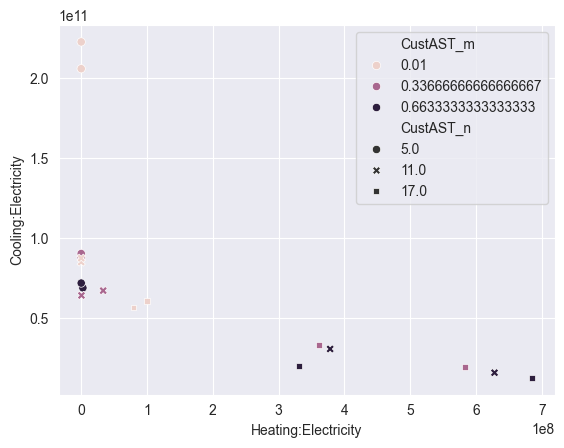

In [50]:
sns.scatterplot(
    data=parametric.outputs_param_simulation,
    x='Heating:Electricity',
    y='Cooling:Electricity',
    hue='CustAST_m',
    style='CustAST_n'
)

#### Time series columns

If you requested some output to be reported in time series, you can get a dataframe containing the hourly values using the method `get_hourly_df()`. This dataframe is saved in the internal variable `outputs_param_simulation_hourly`:

In [51]:
parametric.get_hourly_df()
parametric.outputs_param_simulation_hourly

,CustAST_m,CustAST_n,epw,hour,datetime,Adaptive Cooling Setpoint Temperature_No Tolerance_time series,Adaptive Heating Setpoint Temperature_No Tolerance_time series,Zone Operative Temperature_time series,Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series
0,0.010000,5.0,Sydney,1,2024-01-01 01:00:00,8.694381,1.694381,8.177342,21.325694
1,0.010000,5.0,Sydney,2,2024-01-01 02:00:00,8.713257,1.713257,8.286238,21.325694
2,0.010000,5.0,Sydney,3,2024-01-01 03:00:00,8.713257,1.713257,8.351505,21.325694
3,0.010000,5.0,Sydney,4,2024-01-01 04:00:00,8.713257,1.713257,8.388754,21.325694
4,0.010000,5.0,Sydney,5,2024-01-01 05:00:00,8.713257,1.713257,8.407843,21.325694
...,...,...,...,...,...,...,...,...,...
157675,0.663333,17.0,Seville,8756,2024-12-30 20:00:00,28.274758,21.274758,27.900996,11.720741
157676,0.663333,17.0,Seville,8757,2024-12-30 21:00:00,28.274758,21.274758,27.269178,11.720741
157677,0.663333,17.0,Seville,8758,2024-12-30 22:00:00,28.274758,21.274758,26.536022,11.720741
157678,0.663333,17.0,Seville,8759,2024-12-30 23:00:00,28.274758,21.274758,25.990371,11.720741


Let's prepare the `outputs_param_simulation_hourly` df for plotting:

In [52]:
#Let's make a copy of the dataframe to not to modify the original one
df = parametric.outputs_param_simulation_hourly.copy()

# The name of the column for the Running mean outdoor temperature is very long, so let's save it in the variable rmot:
rmot = [i for i in df.columns if 'Running Average' in i][0]

#Let's remove the columns where value is the same for all rows
for c in df.columns:
    if len(set(df[c])) == 1:
        df = df.drop(columns=[c])
#Now let's remove the hour and datetime columns, since will
df = df.drop(columns=['hour'])

# Now let's reshape the df for plotting purposes
df = df.melt(id_vars=['datetime', 'CustAST_m', 'CustAST_n','epw', rmot])


Firstly, we're going to plot the hourly temperatures to see the slope of the comfort model, and check all hours are within thermal comfort limits (since we applied adaptive setpoints). We're going to plot data only for Seville.

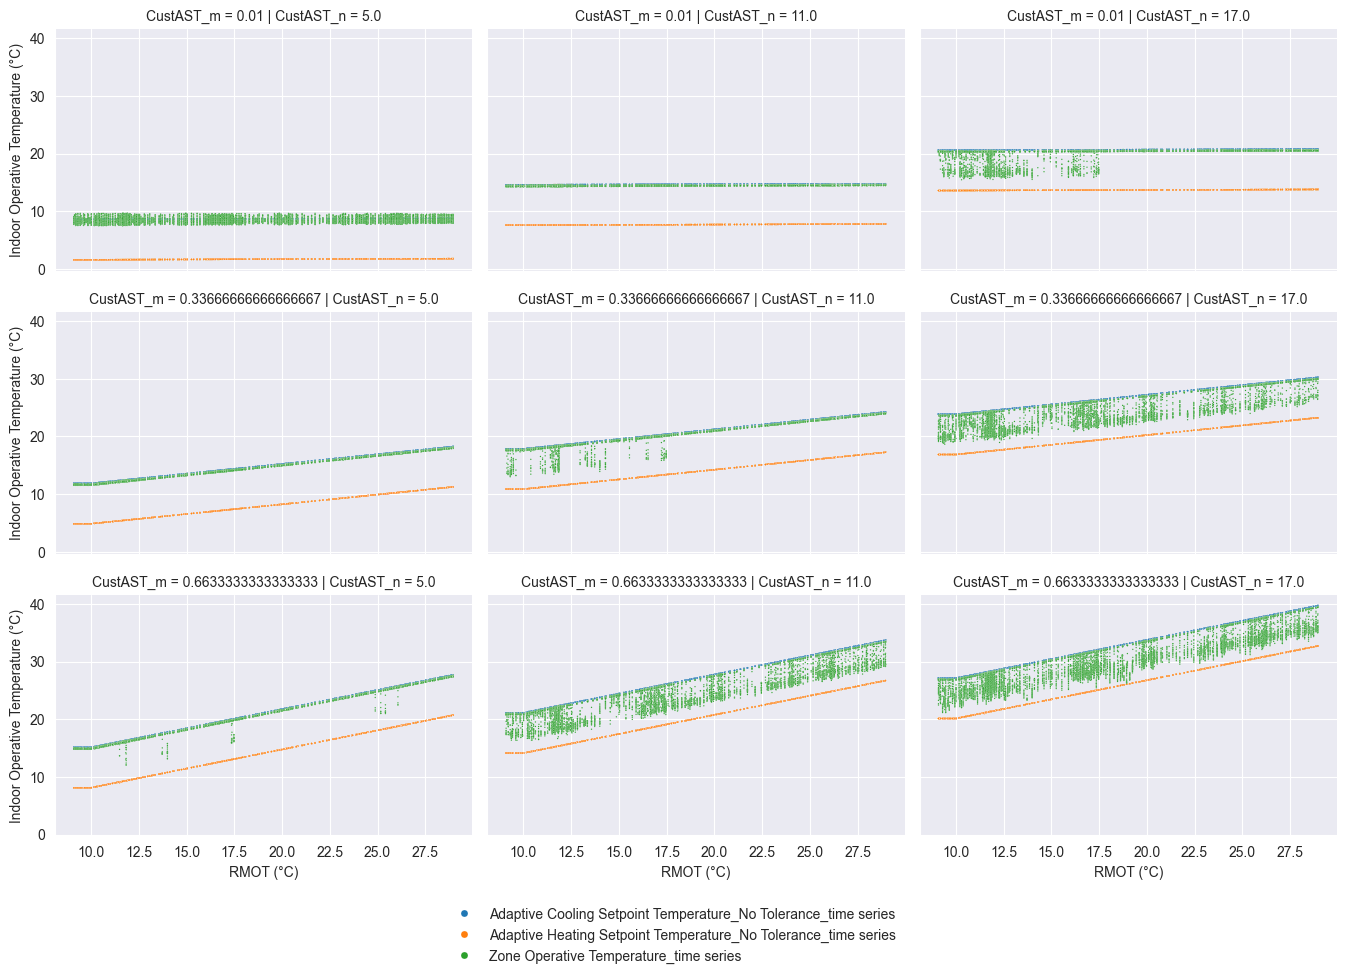

In [53]:
g = sns.FacetGrid(
    data=df[df['epw'].str.contains('Seville')],
    row='CustAST_m',
    col='CustAST_n'
)
g.map_dataframe(
    sns.scatterplot,
    x=rmot,
    y='value',
    hue='variable',
    s=1,
    #alpha=0.5
)
g.set_axis_labels('RMOT (°C)', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))

for lh in g._legend.legend_handles:
    lh.set_markersize(5)
plt.tight_layout()


Now, we're going to plot time on x-axis and change the plot type to lineplot, to see the variarion of the indoor operative temperature throughout the year:

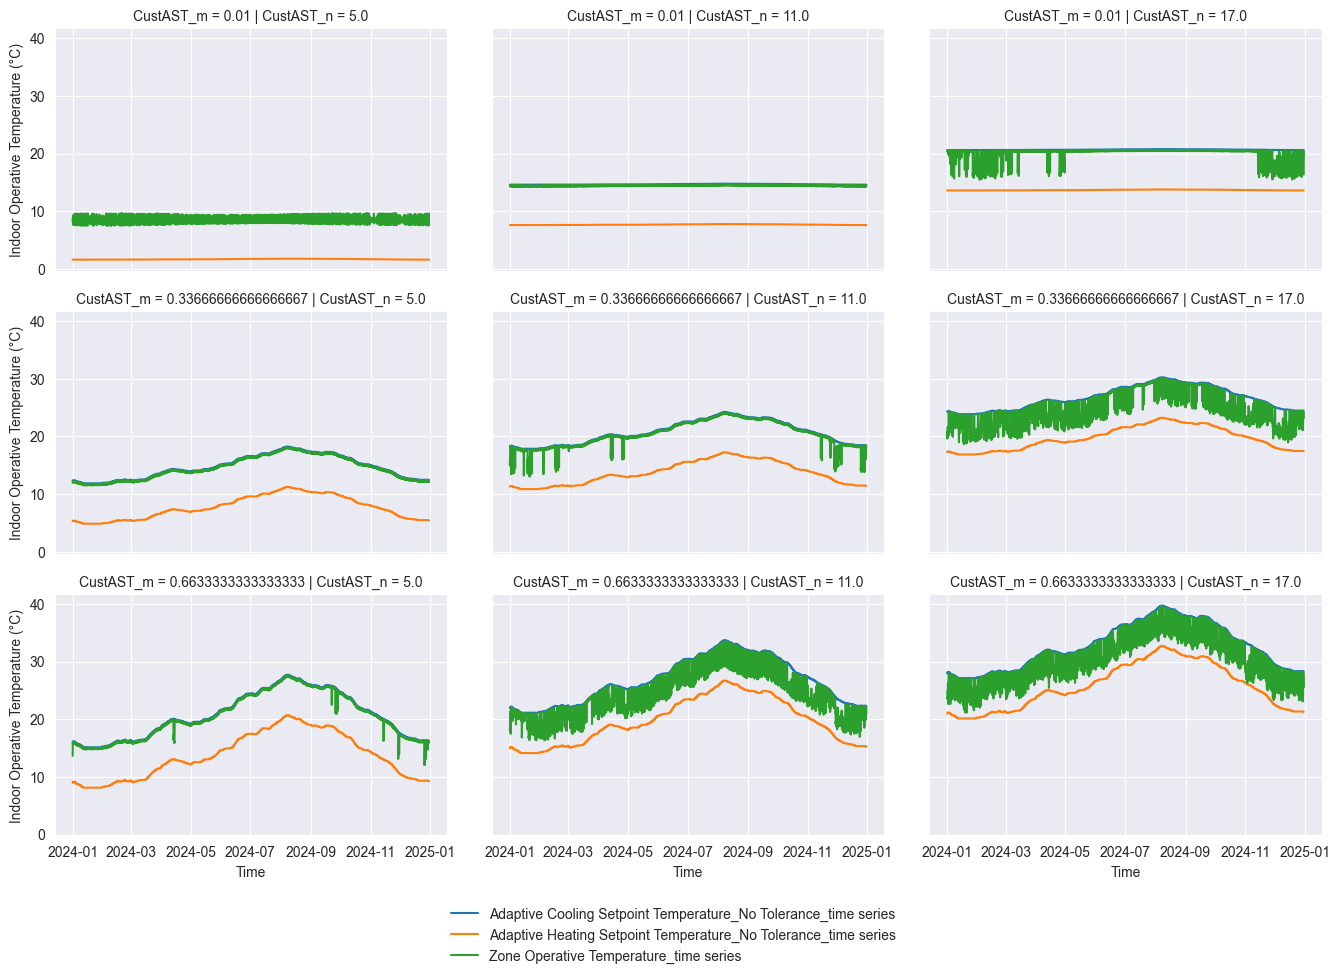

In [54]:
g = sns.FacetGrid(
    data=df[df['epw'].str.contains('Seville')],
    row='CustAST_m',
    col='CustAST_n'
)
g.map_dataframe(
    sns.lineplot,
    x='datetime',
    y='value',
    hue='variable',
)
g.set_axis_labels('Time', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.tight_layout()


We could get also some similar figure for Sydney:

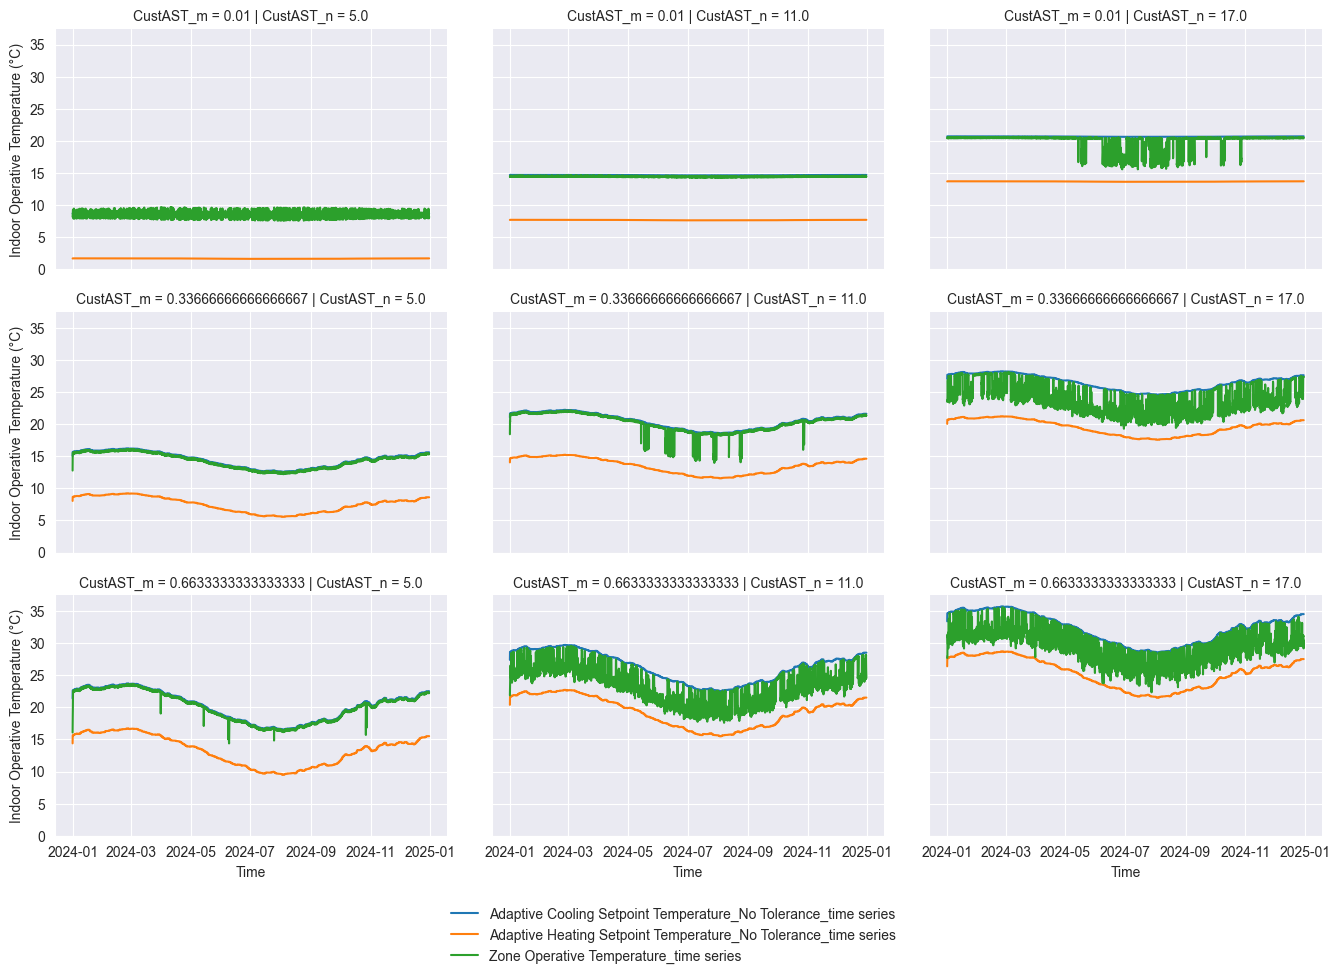

In [55]:
g = sns.FacetGrid(
    data=df[df['epw'].str.contains('Sydney')],
    row='CustAST_m',
    col='CustAST_n'
)
g.map_dataframe(
    sns.lineplot,
    x='datetime',
    y='value',
    hue='variable',
)
g.set_axis_labels('Time', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.tight_layout()

We're done with the example, so let's remove all new files, so that we can re-run it again.

In [56]:
current_files = [i for i in listdir()]
new_files = set(current_files) - set(original_files)
new_files

{'available_outputs', 'notebook_temp_dir'}

In [57]:
import os
import shutil
for item in new_files:
    item_path = os.path.join(os.getcwd(), item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)